# Gradient example: $\nabla_{M_{vir}^{NFW}}$ (time_integration)

In [1]:
import os
from math import pi
from time import time



# os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"  # Use only the first GPU
from autocvd import autocvd
autocvd(num_gpus = 1)

# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

from typing import Optional, Tuple, Callable, Union, List
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import vmap, jit
from jax import random
jax.config.update("jax_enable_x64", True)

import numpy as np
from astropy import units as u
from astropy import constants as c


# from ott.tools.unreg import wassdis_p


import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_MATRIX, DIRECT_ACC_LAXMAP
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, NFW_POTENTIAL, PlummerParams, MN_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity
from odisseo.utils import E_tot, Angular_momentum
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif
from odisseo.potentials import MyamotoNagai, NFW



plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

In [2]:
code_length = 10.0 * u.kpc
code_mass = 1e4 * u.Msun
G = 1 
code_units = CodeUnits(code_length, code_mass, G=G)

In [3]:
# Define the 
config = SimulationConfig(N_particles=1_000, 
                          return_snapshots=False, 
                          num_snapshots=100, 
                          num_timesteps=200, 
                          external_accelerations=(NFW_POTENTIAL,  ), 
                          acceleration_scheme= DIRECT_ACC_MATRIX,
                        #   double_map=True,
                          batch_size=100,
                          softening=(0.1 * u.kpc).to(code_units.code_length).value) #default values

params = SimulationParams(t_end = (5* u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(1e8 * u.Msun).to(code_units.code_mass).value,
                                                        a=(1 * u.kpc).to(code_units.code_length).value),
                          NFW_params = NFWParams(Mvir=(1e12 * u.Msun).to(code_units.code_mass).value,
                                                    r_s = (20 * u.kpc).to(code_units.code_length).value,
                                                    c = 10,),
                          G=G, ) 

print(config)
print(params)

SimulationConfig(N_particles=1000, dimensions=3, return_snapshots=False, num_snapshots=100, fixed_timestep=True, num_timesteps=200, softening=np.float64(0.010000000000000002), integrator=0, diffrax_solver=0, acceleration_scheme=2, batch_size=100, double_map=False, external_accelerations=(0,), differentation_mode=1, num_checkpoints=100)
SimulationParams(G=1, t_end=np.float64(0.03353543704601728), Plummer_params=PlummerParams(a=np.float64(0.1), Mtot=np.float64(10000.0)), NFW_params=NFWParams(Mvir=np.float64(100000000.0), r_s=np.float64(2.0), c=10, d_c=1.4888043637074615), PointMass_params=PointMassParams(M=1.0), MN_params=MNParams(M=65000000000.0, a=3.0, b=0.28), PSP_params=PSPParams(alpha=-1.8, r_c=1.9))


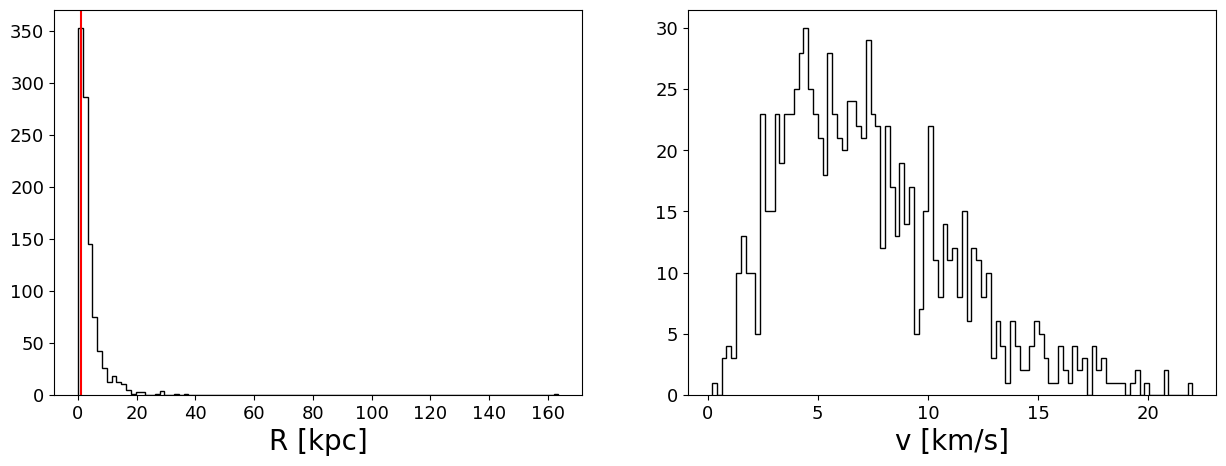

In [4]:
#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(0), params=params, config=config)

#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((jnp.linalg.norm(positions, axis=1) * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.axvline((params.Plummer_params.a*code_units.code_length).to(u.kpc).value, color='r', label='Plummer a')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('v [km/s]')
plt.show()


In [5]:
@jit
def mass_enclosed_NFW(R, params):
    """
    Compute the mass of the NFW potential at a given radius R.

    ref: wikipedia
    """
    c = params.NFW_params.c
    Mvir = params.NFW_params.Mvir
    r_s = params.NFW_params.r_s
    rho_0 = (Mvir / (4*jnp.pi * r_s**3)) * (jnp.log(1+c) - c/(1+c))**-1

    return 4*jnp.pi*rho_0*r_s**3 * (jnp.log(1 + R/r_s) - R/(r_s + R))



In [6]:
# radial distance of the center of mass
rp=200*u.kpc.to(code_units.code_length)

#sampling the center of mass on the sphere
key = random.PRNGKey(42)
num_samples = 1  # Number of positions to generate
pos = sample_position_on_sphere(key, rp, num_samples)
vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
state_com = construct_initial_state(pos, vel)

e = jnp.array(0.0)
inclination = jnp.radians(40)  # 30-degree inclination
mass1 = mass_enclosed_NFW(rp, params)
mass2 = params.Plummer_params.Mtot 
_, bulk_velocity, _ = ic_two_body(mass1=mass1,
                                mass2=mass2,
                                rp=rp,
                                e=e,
                                params=params)
bulk_velocity_modulus = bulk_velocity[1, 1].reshape((1))
vel = inclined_circular_velocity(pos, bulk_velocity_modulus, inclination)


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos
velocities = velocities + vel
initial_state = construct_initial_state(positions, velocities)


#evolve 
target_state = time_integration(initial_state, mass, config, params)
energy_target = E_tot(target_state, mass, config, params)
Lx_target = Angular_momentum(target_state, mass)[:, 0]
Ly_target = Angular_momentum(target_state, mass)[:, 1]
Lz_target = Angular_momentum(target_state, mass)[:, 2]
distribution_r_target = jnp.linalg.norm(target_state[:, 0], axis=1)
hist_target, _ = jnp.histogram(distribution_r_target, bins=100, range=(0, (25*u.kpc).to(code_units.code_length).value))


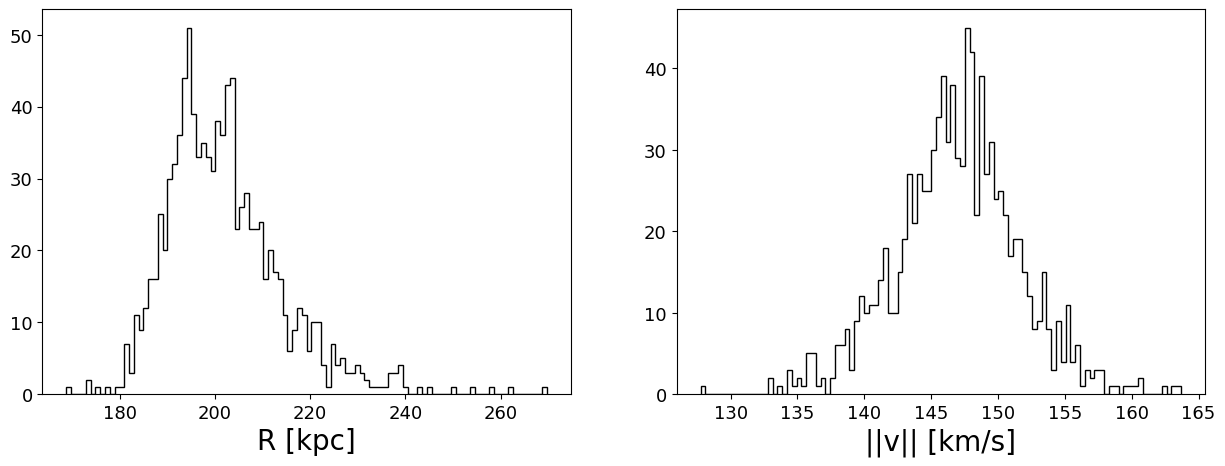

In [7]:
#Plummer sphere distribution
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(121)
ax.hist((distribution_r_target * code_units.code_length).to(u.kpc), bins=100, histtype='step', color='k')
ax.set_xlabel('R [kpc]')

ax = fig.add_subplot(122)
ax.hist(jnp.linalg.norm((velocities * code_units.code_velocity).to(u.km/u.s).value, axis=1), bins=100, histtype='step', color='k')
ax.set_xlabel('||v|| [km/s]')
plt.show()


Text(0.5, 0.92, 'Target state')

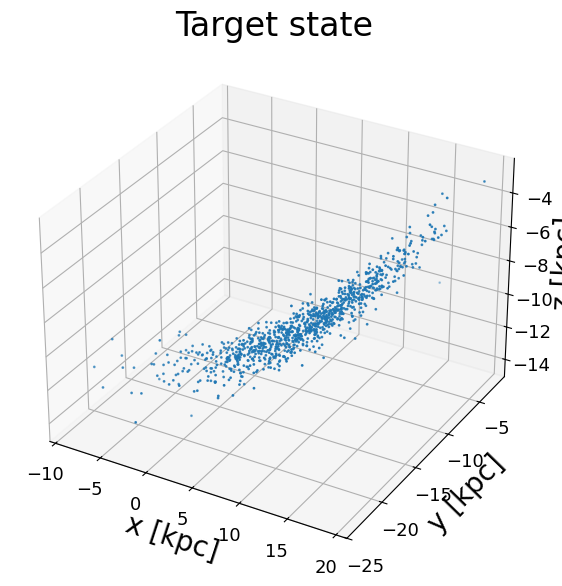

In [8]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(target_state[:, 0, 0], target_state[:, 0, 1], target_state[:, 0, 2], s=1)
ax.set_xlabel('x [kpc]')
ax.set_ylabel('y [kpc]')
ax.set_zlabel('z [kpc]')
# ax.set_xlim(-rp, rp)
# ax.set_ylim(-rp, rp)
# ax.set_zlim(-rp, rp)

ax.set_title('Target state')

(array([  5., 101., 353., 315., 142.,  53.,  23.,   3.,   3.,   2.]),
 array([16.88299536, 17.89169486, 18.90039437, 19.90909388, 20.91779338,
        21.92649289, 22.9351924 , 23.9438919 , 24.95259141, 25.96129091,
        26.96999042]),
 <BarContainer object of 10 artists>)

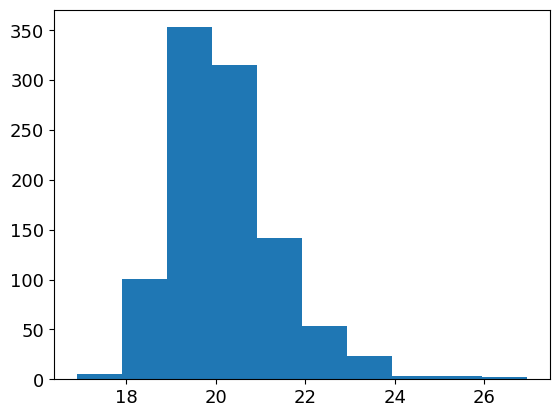

In [9]:
plt.hist(jnp.linalg.norm(target_state[:, 0], axis=1))

In [39]:
def js_divergence(hist1, hist2, epsilon=1e-8):
    hist1 = jnp.clip(hist1, epsilon, 1.0)
    hist2 = jnp.clip(hist2, epsilon, 1.0)
    m = 0.5 * (hist1 + hist2)
    return 0.5 * jnp.sum(hist1 * jnp.log(hist1 / m)) + 0.5 * jnp.sum(hist2 * jnp.log(hist2 / m))

def chi_squared_distance(hist1, hist2, epsilon=1e-8):
    return jnp.sum((hist1 - hist2)**2 / (hist1 + hist2 + epsilon))

def wasserstein_distance(hist1, hist2, ):
    return wassdis_p(hist1, hist2, p=0.01)
    
@jit
def time_integration_for_mass_grad(Mvir, ):
    new_params = params._replace(
    NFW_params=params.NFW_params._replace(
        Mvir=Mvir 
    ))

    # new_params = params._replace(
    # Plummer_params=params.Plummer_params._replace(
    #     Mtot=Mvir 
    # ))

    #set up the particles in the initial state
    positions, velocities, mass = Plummer_sphere(key=random.PRNGKey(int(time())), params=new_params, config=config)
    pos = sample_position_on_sphere(random.PRNGKey(int(time())), rp, num_samples)
    vel = jnp.zeros_like(pos)  # Initialize velocities to zero, it dosen't matter because the acceleration of MyamotoNagai depend only on the postion
    state_com = construct_initial_state(pos, vel)

    e = jnp.array(0.0)
    inclination = jnp.radians(30)  # 30-degree inclination
    mass1 = mass_enclosed_NFW(rp, new_params)
    mass2 = new_params.Plummer_params.Mtot
    _, bulk_velocity, _ = ic_two_body(mass1=mass1,
                                    mass2=mass2,
                                    rp=rp,
                                    e=e,
                                    params=new_params)
    bulk_velocity_modulus = bulk_velocity[1, 1].reshape((1))
    vel = inclined_circular_velocity(pos, bulk_velocity_modulus, inclination)


    # Add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos
    velocities = velocities + vel
    initial_state = construct_initial_state(positions, velocities)
    
    #integrate in time
    final_state = time_integration(initial_state, mass, config, new_params)
    # distribution_r = jnp.linalg.norm(final_state[:, 0], axis=1)
    # hist, _ = jnp.histogram(distribution_r, bins=100, range=(0, (25*u.kpc).to(code_units.code_length).value))
    

    # Calculate the loss

    # loss = jnp.sum(((Lz - Lz_target)/Lz_target)**2)
    # loss = jnp.sum(((energy- energy_target)/energy_target)**2)
    # loss = jnp.sum(((Lz - Lz_target)/Lz_target)**2  + ((energy - energy_target)/energy_target)**2)


    # loss = js_divergence(hist, hist_target) 
    # loss = chi_squared_distance(hist, hist_target)
    # loss = wasserstein_distance(hist[None, :], hist_target[None, :])
    # energy_min, energy_max =jnp.min(energy), jnp.max(energy)
    # hist_energy, _  = jnp.histogram(energy, bins=100, range=(energy_min, energy_max))
    # hist_energy_target, _ = jnp.histogram(energy_target, bins=100, range=(energy_min, energy_max))

    # Lz_min, Lz_max = jnp.min(Lz), jnp.max(Lz)
    # hist_Lz, _  = jnp.histogram(Lz, bins=100, range=(Lz_min, Lz_max))
    # hist_Lz_target, _ = jnp.histogram(Lz_target, bins=100, range=(Lz_min, Lz_max))
    # loss = js_divergence(hist_energy, hist_energy_target) + js_divergence(hist_Lz, hist_Lz_target)

    ## Calculate the loss using kde, dosen't work
    # energy, Lz = E_tot(final_state, mass, config, new_params), Angular_momentum(final_state, mass, )[:, 2]
    # kde_energy = jax.scipy.stats.gaussian_kde(energy)
    # energy_lim = jnp.linspace(-1.0, 1.0, bins)
    # m_energy = jnp.meshgrid(energy_lim, indexing='ij')
    # counts_energy = kde_energy.evaluate(jnp.array([m_energy[0].reshape(-1)])).reshape(-1)
    # counts_energy /= jnp.sum(counts_energy)

    # kde_Lz = jax.scipy.stats.gaussian_kde(Lz)
    # Lz_lim = jnp.linspace(-1.0, 1.0, bins)
    # m_Lz = jnp.meshgrid(Lz_lim, indexing='ij')
    # counts_Lz = kde_Lz.evaluate(jnp.array([m_Lz[0].reshape(-1)])).reshape(-1)
    # counts_Lz /= jnp.sum(counts_Lz)

    # loss = jnp.sum((counts_energy - energy_target_hist)**2 + (counts_Lz - Lz_target_hist)**2)



    ##smooth instrogram approach, should not kill the gradient
    # def soft_histogram(values, bin_centers, sigma=0.1):
    #     """Differentiable soft histogram using Gaussian kernels"""
    #     # values: (N,) array of data points
    #     # bin_centers: (M,) array of bin centers
    #     # sigma: smoothing parameter
        
    #     diff = values[:, None] - bin_centers[None, :]  # (N, M)
    #     weights = jnp.exp(-0.5 * (diff / sigma)**2)    # Gaussian weights
    #     hist = jnp.mean(weights, axis=0)               # Average over particles
    #     return hist
    
    # energy, Lz = E_tot(final_state, mass, config, new_params), Angular_momentum(final_state, mass, )[:, 2]
    # bin_center_energy = jnp.linspace(min_energy, max_energy, bins)
    # energy_hist = soft_histogram(energy, bin_center_energy)
    # jax.debug.print('{energy_hist}', energy_hist=energy_hist)
    # bin_center_Lz = jnp.linspace(min_Lz, max_Lz, bins)
    # Lz_hist = soft_histogram(Lz, bin_center_Lz)
    # energy_hist /= jnp.sum(energy_hist)
    # Lz_hist /= jnp.sum(Lz_hist)
    # loss = jnp.sum((energy_hist - energy_target_hist_soft)**2 + (Lz_hist - Lz_target_hist_soft)**2)


    ##Quite noisy kde approach, dosen't kill the gradient
    # energy, Lz = E_tot(final_state, mass, config, new_params), Angular_momentum(final_state, mass, )[:, 2]
    # energy_angular_momentum = jnp.concatenate((energy.reshape(-1, 1), Lz.reshape(-1, 1)), axis=1)
    # energy_lim = jnp.linspace(-1.0, 1.0, bins)
    # Lz_lim = jnp.linspace(-1.0, 1.0, bins)
    # kde_energy_angular_momentum = jax.scipy.stats.gaussian_kde(energy_angular_momentum.T)
    # e, l = jnp.meshgrid(energy_lim, Lz_lim, indexing='ij')
    # counts_energy_angular_momentum = kde_energy_angular_momentum.evaluate(
    #     jnp.array([e.reshape(-1), l.reshape(-1)])).reshape((bins, bins))
    # counts_energy_angular_momentum /= jnp.sum(counts_energy_angular_momentum)
    # loss = jnp.sum((counts_energy_angular_momentum - energy_angular_momentum_target)**2)

    @jit
    def energy_invariant_loss(final_state, energy_target, Lz_target):
        """Loss based on energy and angular momentum distributions"""
        
        # These quantities are already permutation invariant
        energy_final = E_tot(final_state, mass, config, new_params)
        Lx_final = Angular_momentum(final_state, mass)[:, 0]
        Ly_final = Angular_momentum(final_state, mass)[:, 1] 
        Lz_final = Angular_momentum(final_state, mass)[:, 2]
        
        
        # Compare distributions
        loss = ((jnp.mean(energy_final) - jnp.mean(energy_target))**2 +
            (jnp.std(energy_final) - jnp.std(energy_target))**2 +
            (jnp.mean(Lx_final) - jnp.mean(Lx_target))**2 +
            (jnp.mean(Ly_final) - jnp.mean(Ly_target))**2 +
            (jnp.mean(Lz_final) - jnp.mean(Lz_target))**2 +
            (jnp.std(Lz_final) - jnp.std(Lz_target))**2)
    
        return loss
    
    @jit
    def energy_invariant_loss_in_simulation(final_state, target_state):
        """Loss based on energy and angular momentum distributions"""
        
        # These quantities are already permutation invariant
        energy_final = E_tot(final_state, mass, config, new_params)
        Lx_final = Angular_momentum(final_state, mass)[:, 0]
        Ly_final = Angular_momentum(final_state, mass)[:, 1] 
        Lz_final = Angular_momentum(final_state, mass)[:, 2]
        
        energy_target = E_tot(target_state, mass, config, new_params)
        Lx_target = Angular_momentum(target_state, mass)[:, 0]
        Ly_target = Angular_momentum(target_state, mass)[:, 1] 
        Lz_target = Angular_momentum(target_state, mass)[:, 2]
        
    
        return jnp.sum(((Lx_final - Lx_target)/Lx_target)**2 + ((Ly_final - Ly_target)/Ly_target)**2 + ((Lz_final - Lz_target)/Lz_target)**2 + ((energy_final - energy_target)/energy_target)**2)

    @jit 
    def energy_momentum_loss(final_state, energy_target, Lz_target):
        """Loss based on energy and angular momentum distributions"""
        
        # These quantities are already permutation invariant
        energy_final = E_tot(final_state, mass, config, new_params)
        Lz_final = Angular_momentum(final_state, mass)[:, 2]
        
    
        return jnp.sum(((Lz_final - Lz_target)/Lz_target)**2  + ((energy_final - energy_target)/energy_target)**2)
    
    
    #THIS ONE WORKS THE BEST FOR NOW
    @jit
    def permutation_invariant_momentum_loss(final_state, target_state):
        """Loss based on statistical moments - invariant to particle ordering"""
        
        # Extract positions and velocities
        final_pos = final_state[:, 0]  # (N, 3)
        target_pos = target_state[:, 0]  # (N, 3)
        final_vel = final_state[:, 1]  # (N, 3)
        target_vel = target_state[:, 1]  # (N, 3)
        
        # Radial distances
        final_r = jnp.linalg.norm(final_pos, axis=1)
        target_r = jnp.linalg.norm(target_pos, axis=1)
        
        # Velocity magnitudes
        final_v = jnp.linalg.norm(final_vel, axis=1)
        target_v = jnp.linalg.norm(target_vel, axis=1)
        
        # Statistical moments (all permutation-invariant)
        loss = 0.0
        
        # Position moments
        loss += (jnp.mean(final_r) - jnp.mean(target_r))**2  # Mean radius
        loss += (jnp.std(final_r) - jnp.std(target_r))**2    # Std radius
        
        # Velocity moments
        loss += (jnp.mean(final_v) - jnp.mean(target_v))**2
        loss += (jnp.std(final_v) - jnp.std(target_v))**2
        
        return loss
    
    @jit
    def permutation_invariant_loss(final_state, target_state):
        range = (0, 100)
        bins = 100
        hist_target_r, _ = jnp.histogram(distribution_r_target, range=range, bins=bins,)
        hist_target_r = hist_target_r / jnp.sum(hist_target_r)  # Normalize
        distribution_r_final = jnp.linalg.norm(final_state[:, 0], axis=1)
        kde_r = jax.scipy.stats.gaussian_kde(distribution_r_final)
        r_lim = jnp.linspace(range[0], range[1], 100)
        m_r = jnp.meshgrid(r_lim, indexing='ij')
        counts_r = kde_r.evaluate(jnp.array([m_r[0].reshape(-1)])).reshape(-1)
        counts_r /= jnp.sum(counts_r)
        loss = jnp.sum((counts_r - hist_target_r)**2)

        return loss


    
    @jit
    def position_velocity_loss(final_state, target_state):
        """Loss based on position and velocity distributions"""
        
        # Extract positions and velocities
        final_pos = final_state[:, 0]
        target_pos = target_state[:, 0]
        final_vel = final_state[:, 1]
        target_vel = target_state[:, 1]
        
        return jnp.sum(((final_pos - target_pos)/target_pos)**2) 
    
    # loss = permutation_invariant_momentum_loss(final_state, target_state)
    loss = permutation_invariant_loss(final_state, target_state)
    # loss = energy_invariant_loss(final_state, energy_target, Lz_target)
    # loss = energy_invariant_loss_in_simulation(final_state, target_state)
    # loss = energy_momentum_loss(final_state, energy_target, Lz_target)
    # loss = position_velocity_loss(final_state, target_state)
    
    return loss


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = (1e11 * u.Msun).to(code_units.code_mass).value
loss, grad = jax.value_and_grad(time_integration_for_mass_grad)(Mvir, )
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

Gradient of the total mass of the Mvir of NFW:
 9.099764049717115e-11
Loss:
 0.09190674237164859


2025-06-03 12:05:40.543332: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 11.49GiB (12338262147 bytes) by rematerialization; only reduced to 20.30GiB (21802327646 bytes), down from 20.31GiB (21809527806 bytes) originally


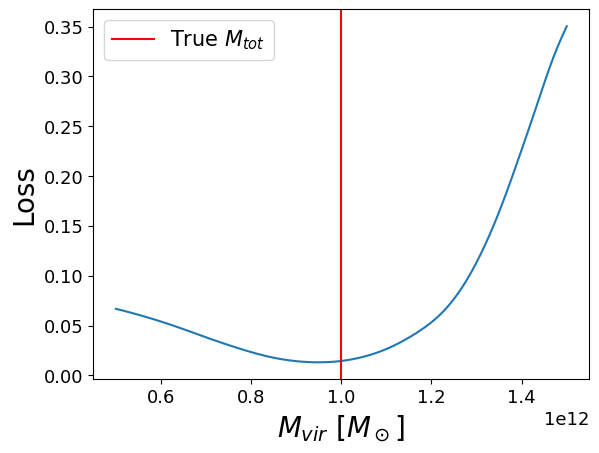

In [40]:
Mvir =  (jnp.linspace(0.5*1e12, 1.5*1e12, 100) * u.Msun).to(code_units.code_mass).value
loss, grad = vmap(jax.value_and_grad(time_integration_for_mass_grad))(Mvir)

plt.figure()
plt.plot((Mvir*code_units.code_mass).to(u.Msun), loss)
plt.axvline((1e12 * u.Msun).value, color='r', label='True $M_{tot}$')
plt.xlabel("$M_{vir}$ [$M_\odot$]")
# plt.xscale('log')
plt.ylabel('Loss')
plt.legend()


In [25]:
kde_r = jax.scipy.stats.gaussian_kde(distribution_r_target.T)


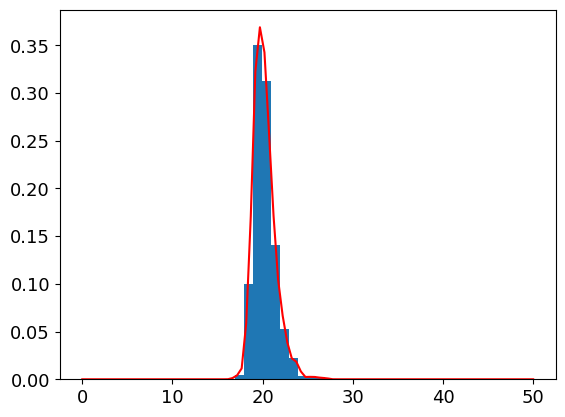

In [34]:
plt.hist(distribution_r_target, density=True)
plt.plot(jnp.linspace(0, 50, 100), kde_r.evaluate(jnp.linspace(0, 50, 100)), label='KDE', color='r')

In [ ]:
hist_target_r, _ = jnp.histogram(distribution_r_target, range=(0, 100), bins=100, )